### Import Required Library 

In [ ]:
import os
import pandas as pd
import unmpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

### Using GPU acceleration

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Split Train, Validate, and Test

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

strat1 = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat1)

strat2 = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat2)


tr_gen = tf.keras.preprocessing.image.ImageDataGenerator()
ts_gen = tf.keras.preprocessing.image.ImageDataGenerator()


train_ds = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

valid_ds = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

test_ds = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

Found 3839 validated image filenames belonging to 4 classes.
Found 450 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.


### Augmentation data

In [ ]:

# All Augmentation
def augmentation():
    augmentation_img = tf.keras.preprocessing.image.ImageDataGenerator( 
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True, 
        fill_mode='nearest' 
        ) 
    return augmentation_img

### Customize Callback 
* Checkpoint
* Earlystop
* Note the history epoch 

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping


model_dir = 'model'

class CustomCallback(Callback):
    def __init__(self, validation_data):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss', None)
        val_accuracy = logs.get('val_accuracy', None)

        
        with open("training_log.txt", "a") as f:
            f.write(f"Epoch {epoch + 1}: Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}\n")

        
        if val_accuracy and val_accuracy > 0.98:
            print("Validation accuracy exceeded 98%. Stopping training!")
            self.model.stop_training = True


checkpoint = ModelCheckpoint(
    
    filepath=os.path.join(model_dir, 'best_model.keras'), 
    monitor='val_accuracy',      
    save_best_only=True,         
    mode='max',                   
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',        
    patience=10,               
    verbose=1,                  
    restore_best_weights=True   
)

### Make Sequence Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

def model_1():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    return model

### Summary model

In [13]:
model = model_1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

### Initialize Augmented to data

In [15]:
train_ds = augmentation()

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_ds = train_ds.flow_from_directory(
    'data',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_gen = valid_gen.flow_from_directory(
    'data',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4740 images belonging to 4 classes.
Found 4740 images belonging to 4 classes.


### Compile and Train data

In [16]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(
    train_ds,                              # Dataset pelatihan
    validation_data=valid_ds,              # Dataset validasi
    epochs=100,                             # Maksimal epoch
    callbacks=callbacks,                   # Menggunakan callback
    verbose=1                              # Progress output
)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 8.2456 - accuracy: 0.6582
Epoch 1: val_accuracy improved from -inf to 0.71778, saving model to model\best_model.keras
149/149 [==============================] - 95s 578ms/step - loss: 8.2456 - accuracy: 0.6582 - val_loss: 0.6444 - val_accuracy: 0.7178
Epoch 2/100
149/149 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7709
Epoch 2: val_accuracy improved from 0.71778 to 0.82222, saving model to model\best_model.keras
149/149 [==============================] - 34s 231ms/step - loss: 0.6274 - accuracy: 0.7709 - val_loss: 0.5544 - val_accuracy: 0.8222
Epoch 3/100
149/149 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.7914
Epoch 3: val_accuracy did not improve from 0.82222
149/149 [==============================] - 71s 474ms/step - loss: 0.5829 - accuracy: 0.7914 - val_loss: 0.5593 - val_accuracy: 0.8111
Epoch 4/100
149/149 [==============================] - ETA: 0s - loss

### Plot train history function

In [17]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

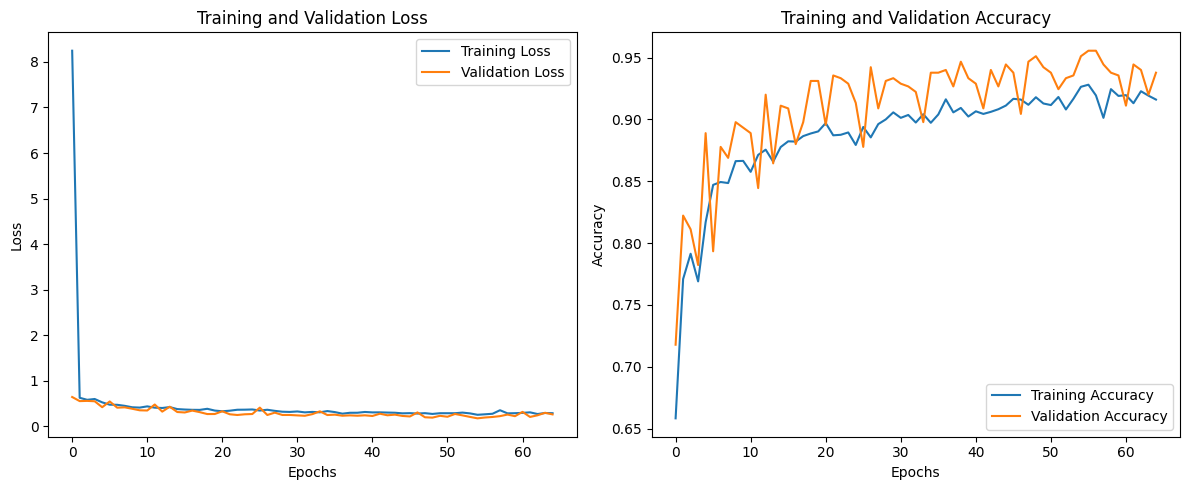

In [18]:
plot_history(history)

### Evaluate model

In [ ]:

import tensorflow as tf
import os
model_dir = 'model'
best_model = tf.keras.models.load_model(os.path.join(model_dir, 'best_model.keras'))

#evaluate
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 1s 72ms/step - loss: 0.2107 - accuracy: 0.9534
Test Loss: 0.21069271862506866
Test Accuracy: 0.9534367918968201


### Evaluate data with test data

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_ds, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_ds, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 1s 52ms/step - loss: 0.2163 - accuracy: 0.9489
Train Loss:  0.2208385020494461
Train Accuracy:  0.9431818127632141
--------------------
Valid Loss:  0.20041890442371368
Valid Accuracy:  0.9545454382896423
--------------------
Test Loss:  0.21632042527198792
Test Accuracy:  0.9488636255264282


### Predict image with upload image

In [1]:
import tensorflow as tf
import numpy as np
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display

# Load the model
model = tf.keras.models.load_model('model/best_model.keras')

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(224, 224))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:
        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["Blight", "Common", "Gray", "Healthy"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')

def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    items = change.new
    for item in items:  # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

### Save model

In [7]:
import tensorflow as tf

# Assuming 'model' is your Keras model
model = tf.keras.models.load_model('model/best_model.keras')

# Save the model in H5 format
model.save('model/best_model.h5')